# Gabor Filter

This notebook is used as verification that the Gabor filter generated is correct by examining several 2D and 3D cases. 

In [19]:
from brainlit.preprocessing import gabor_filter
from skimage.filters import gabor
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import scipy.ndimage as ndi

## 2D Case

Skimage has a 2D implementation of Gabor. Some arguments are in slightly different units and must be converted.

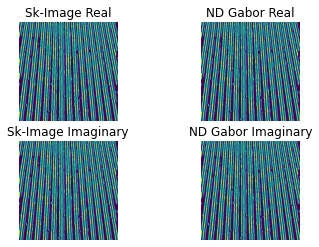

In [22]:
img = data.brick()
frequency = 0.1
std_x = 5
std_y = 5
offset = 2

skimage = gabor(img, frequency, theta=0, sigma_x=std_x, sigma_y=std_y, n_stds=3, offset=offset, mode='reflect', cval=0)
nd = gabor_filter(img, [std_x, std_y], 0, frequency, truncate=3, offset=offset)

plt.subplot(2,2,1)
plt.imshow(skimage[0])
plt.title("Sk-Image Real")
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(nd[0])
plt.title("ND Gabor Real")
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(skimage[1])
plt.title("Sk-Image Imaginary")
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(nd[1])
plt.title("ND Gabor Imaginary")
plt.axis('off')
plt.show()

np.testing.assert_allclose(skimage[0], nd[0])
np.testing.assert_allclose(skimage[1], nd[1])

The only parameter that is different is the orientation. This is because scikit-image rotates the Gaussian kernel, but our implementation does not. Below is the scikit-image implementation, without the Gaussian rotation.

In [23]:
def gabor_kernel_edit(frequency, theta=0, bandwidth=1, sigma_x=None, sigma_y=None,
                 n_stds=3, offset=0):
    """Return complex 2D Gabor filter kernel.
    Gabor kernel is a Gaussian kernel modulated by a complex harmonic function.
    Harmonic function consists of an imaginary sine function and a real
    cosine function. Spatial frequency is inversely proportional to the
    wavelength of the harmonic and to the standard deviation of a Gaussian
    kernel. The bandwidth is also inversely proportional to the standard
    deviation.
    Parameters
    ----------
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
    bandwidth : float, optional
        The bandwidth captured by the filter. For fixed bandwidth, ``sigma_x``
        and ``sigma_y`` will decrease with increasing frequency. This value is
        ignored if ``sigma_x`` and ``sigma_y`` are set by the user.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that ``sigma_x`` controls the *vertical*
        direction.
    n_stds : scalar, optional
        The linear size of the kernel is n_stds (3 by default) standard
        deviations
    offset : float, optional
        Phase offset of harmonic function in radians.
    Returns
    -------
    g : complex array
        Complex filter kernel.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Gabor_filter
    .. [2] https://web.archive.org/web/20180127125930/http://mplab.ucsd.edu/tutorials/gabor.pdf
    Examples
    --------
    >>> from skimage.filters import gabor_kernel
    >>> from skimage import io
    >>> from matplotlib import pyplot as plt  # doctest: +SKIP
    >>> gk = gabor_kernel(frequency=0.2)
    >>> plt.figure()        # doctest: +SKIP
    >>> io.imshow(gk.real)  # doctest: +SKIP
    >>> io.show()           # doctest: +SKIP
    >>> # more ripples (equivalent to increasing the size of the
    >>> # Gaussian spread)
    >>> gk = gabor_kernel(frequency=0.2, bandwidth=0.1)
    >>> plt.figure()        # doctest: +SKIP
    >>> io.imshow(gk.real)  # doctest: +SKIP
    >>> io.show()           # doctest: +SKIP
    """

    x0 = np.ceil(np.abs(n_stds * sigma_x)) # Changed this line
    y0 = np.ceil(np.abs(n_stds * sigma_y)) # Changed this line
    y, x = np.mgrid[-y0:y0 + 1, -x0:x0 + 1]

    rotx = x * np.cos(theta) + y * np.sin(theta)
    roty = -x * np.sin(theta) + y * np.cos(theta)

    g = np.zeros(y.shape, dtype=np.complex)
    g[:] = np.exp(-0.5 * ((x/ sigma_x) ** 2 + (y/ sigma_y) ** 2)) # Changed this line
    g /= 2 * np.pi * sigma_x * sigma_y
    g *= np.exp(1j * (2 * np.pi * frequency * rotx + offset))

    return g


def gabor_edit(image, frequency, theta=0, bandwidth=1, sigma_x=None,
          sigma_y=None, n_stds=3, offset=0, mode='reflect', cval=0):
    """Return real and imaginary responses to Gabor filter.
    The real and imaginary parts of the Gabor filter kernel are applied to the
    image and the response is returned as a pair of arrays.
    Gabor filter is a linear filter with a Gaussian kernel which is modulated
    by a sinusoidal plane wave. Frequency and orientation representations of
    the Gabor filter are similar to those of the human visual system.
    Gabor filter banks are commonly used in computer vision and image
    processing. They are especially suitable for edge detection and texture
    classification.
    Parameters
    ----------
    image : 2-D array
        Input image.
    frequency : float
        Spatial frequency of the harmonic function. Specified in pixels.
    theta : float, optional
        Orientation in radians. If 0, the harmonic is in the x-direction.
    bandwidth : float, optional
        The bandwidth captured by the filter. For fixed bandwidth, ``sigma_x``
        and ``sigma_y`` will decrease with increasing frequency. This value is
        ignored if ``sigma_x`` and ``sigma_y`` are set by the user.
    sigma_x, sigma_y : float, optional
        Standard deviation in x- and y-directions. These directions apply to
        the kernel *before* rotation. If `theta = pi/2`, then the kernel is
        rotated 90 degrees so that ``sigma_x`` controls the *vertical*
        direction.
    n_stds : scalar, optional
        The linear size of the kernel is n_stds (3 by default) standard
        deviations.
    offset : float, optional
        Phase offset of harmonic function in radians.
    mode : {'constant', 'nearest', 'reflect', 'mirror', 'wrap'}, optional
        Mode used to convolve image with a kernel, passed to `ndi.convolve`
    cval : scalar, optional
        Value to fill past edges of input if ``mode`` of convolution is
        'constant'. The parameter is passed to `ndi.convolve`.
    Returns
    -------
    real, imag : arrays
        Filtered images using the real and imaginary parts of the Gabor filter
        kernel. Images are of the same dimensions as the input one.
    References
    ----------
    .. [1] https://en.wikipedia.org/wiki/Gabor_filter
    .. [2] https://web.archive.org/web/20180127125930/http://mplab.ucsd.edu/tutorials/gabor.pdf
    Examples
    --------
    >>> from skimage.filters import gabor
    >>> from skimage import data, io
    >>> from matplotlib import pyplot as plt  # doctest: +SKIP
    >>> image = data.coins()
    >>> # detecting edges in a coin image
    >>> filt_real, filt_imag = gabor(image, frequency=0.6)
    >>> plt.figure()            # doctest: +SKIP
    >>> io.imshow(filt_real)    # doctest: +SKIP
    >>> io.show()               # doctest: +SKIP
    >>> # less sensitivity to finer details with the lower frequency kernel
    >>> filt_real, filt_imag = gabor(image, frequency=0.1)
    >>> plt.figure()            # doctest: +SKIP
    >>> io.imshow(filt_real)    # doctest: +SKIP
    >>> io.show()               # doctest: +SKIP
    """
    g = gabor_kernel_edit(frequency, theta, bandwidth, sigma_x, sigma_y, n_stds,
                     offset)

    filtered_real = ndi.convolve(image, np.real(g), mode=mode, cval=cval)
    filtered_imag = ndi.convolve(image, np.imag(g), mode=mode, cval=cval)

    return filtered_real, filtered_imag

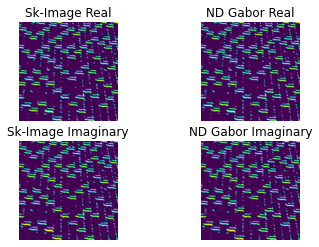

In [24]:
img = data.brick()
frequency = 0.1
std_x = 5
std_y = 5
offset = 2
orientation = 2

skimage = gabor_edit(img, frequency, theta=orientation, sigma_x=std_x, sigma_y=std_y, n_stds=3, offset=offset, mode='reflect', cval=0)
nd = gabor_filter(img, [std_x, std_y], orientation, frequency, truncate=3, offset=offset)

plt.subplot(2,2,1)
plt.imshow(skimage[0])
plt.title("Sk-Image Real")
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(nd[0])
plt.title("ND Gabor Real")
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(skimage[0])
plt.title("Sk-Image Imaginary")
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(nd[0])
plt.title("ND Gabor Imaginary")
plt.axis('off')
plt.show()

np.testing.assert_allclose(skimage[0], nd[0])
np.testing.assert_allclose(skimage[1], nd[1])

# 3D Images

Currently, there is no package that offers a 3D implementation. Below is a hard-coded 3D Gabor filter based off of skimage PR: https://github.com/scikit-image/scikit-image/blob/ccb58ab938951fa43474413dfe96615b594bcbcc/skimage/filters/_gabor.py#L19

In [27]:
def gabor_kernel_3D(frequency, alpha=0, beta=0, bandwidth=1, sigma_x=None, sigma_y=None, sigma_z=None, n_stds=3, offset=0):

    """
    R = [[ cos(alpha) * sin(beta), -sin(alpha), -cos(alpha) * cos(beta) ],
         [ sin(alpha) * sin(beta),  cos(alpha), -sin(alpha) * cos(beta) ],
         [              cos(beta),           0,               sin(beta) ]]
    """
    x0 = np.ceil(np.abs(n_stds * sigma_x))
    y0 = np.ceil(np.abs(n_stds * sigma_y))
    z0 = np.ceil(np.abs(n_stds * sigma_z))
    
    y, x, z = np.mgrid[-y0:y0 + 1, -x0:x0 + 1, -z0:z0 + 1]

    rotx = (x * np.cos(alpha) * np.sin(beta)
            + y * np.sin(alpha) * np.sin(beta)
            + z * np.cos(beta))

    g = np.zeros(y.shape, dtype=np.complex)
    g[:] = np.exp(-0.5 * (x ** 2 / sigma_x ** 2
                          + y ** 2 / sigma_y ** 2
                          + z ** 2 / sigma_z ** 2))
    g /= (2 * np.pi) ** (3 / 2) * sigma_x * sigma_y * sigma_z
    g *= np.exp(1j * (2 * np.pi * frequency
                      * (x * np.sin(beta) * np.cos(alpha)
                         + y * np.sin(beta) * np.sin(alpha)
                         + z * np.cos(beta))
                      + offset))

    return g


def gabor_3D(image, frequency, alpha=0, beta=0, bandwidth=1, sigma_x=None,
              sigma_y=None, sigma_z=None, n_stds=3, offset=0, mode='reflect', cval=0):
    g = gabor_kernel_3D(frequency, alpha, beta, bandwidth, sigma_x, sigma_y, sigma_z, n_stds, offset)

    filtered_real = ndi.convolve(image, np.real(g), mode=mode, cval=cval)
    filtered_imag = ndi.convolve(image, np.imag(g), mode=mode, cval=cval)

    return filtered_real, filtered_imag

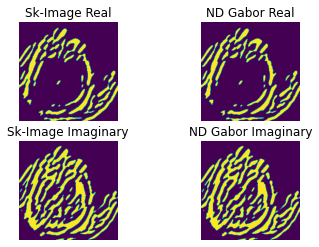

In [31]:
img = data.brain() # Need Ryan's development version of scikit image installed to use this
frequency = 0.1
std_x = 5
std_y = 5
std_z = 5
offset = 0
alpha = 1
beta = 1

skimage = gabor_3D(img, frequency, alpha = alpha, beta = beta, sigma_x=std_x, sigma_y=std_y, sigma_z = std_z, n_stds=3, offset=offset, mode='reflect', cval=0)
nd = gabor_filter(img, [std_x, std_y, std_z], [alpha, beta], frequency, truncate=3, offset=offset)

plt.subplot(2,2,1)
plt.imshow(skimage[0][0])
plt.title("Sk-Image Real")
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(nd[0][0])
plt.title("ND Gabor Real")
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(skimage[1][0])
plt.title("Sk-Image Imaginary")
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(nd[1][0])
plt.title("ND Gabor Imaginary")
plt.axis('off')
plt.show()

np.testing.assert_allclose(skimage[0], nd[0])
np.testing.assert_allclose(skimage[1], nd[1])